In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import numpy as np

In [19]:
# Set random seed for reproducibility
np.random.seed(42)

In [20]:
class GNB:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.variances = {}
        self.classes = []
    
    def fit(self, X, y):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
            
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / n_samples
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0)
    
    def gaussian_pdf(self, x, mean, var, epsilon=1e-9):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(x, pd.Series):
            x = x.values
        if isinstance(mean, pd.Series):
            mean = mean.values
        if isinstance(var, pd.Series):
            var = var.values
            
        return (1 / np.sqrt(2 * np.pi * (var + epsilon))) * np.exp(-((x - mean) ** 2) / (2 * (var + epsilon)))
    
    def predict_proba(self, X):
        # Convert to numpy array if it's a pandas object
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        probs = []
        for x in X:
            posterior_probs = {}
            for c in self.classes:
                prior = np.log(self.priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))
                posterior_probs[c] = prior + likelihood
            
            # Convert log probabilities to probabilities using softmax
            exp_probs = np.exp(list(posterior_probs.values()))
            softmax_probs = exp_probs / np.sum(exp_probs)
            probs.append(softmax_probs)
        
        return np.array(probs)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

NB - Unbalanced Dataset

In [21]:
# Load dataset
df = pd.read_csv("./Binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,-1.944044,1.891310,5.378017,-1.099764,0.319998,-0.107990,0.192998,-0.531588,-1.978358,0.505306,...,0.435838,-0.375777,-2.410484,1.307302,-0.447091,-1.205613,-0.758668,-1.115528,1.219782,1
1,0.548890,3.689146,-1.079215,-1.125497,6.892610,-0.114086,-0.129833,-4.471123,1.281707,2.509007,...,-0.515136,-1.814937,-0.659753,0.092014,1.173449,-0.887015,-0.657684,0.676340,0.379053,1
2,1.044743,2.804073,-1.779122,-0.358211,6.132624,-1.309396,-0.731316,-3.381683,-1.444734,3.028355,...,-0.928873,-1.592203,-0.389953,0.343527,0.740160,-0.244341,-1.337129,-0.168281,-0.464880,1
3,-2.848743,-2.220174,-0.498797,-0.054547,0.073406,0.927517,1.891807,-0.381548,0.017551,0.659493,...,0.662054,0.671306,-0.463003,-0.170516,0.249816,0.019505,-0.380889,-0.222127,0.364851,1
4,-0.715628,0.217362,2.032461,-0.144826,4.375660,-1.762026,1.335940,1.742721,-1.771379,0.819612,...,-0.428352,-0.511074,-0.346423,0.137622,-0.289325,-1.089344,-0.407556,-0.007071,0.117600,1


In [22]:
# Check class distribution
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
1    464
0     80
Name: count, dtype: int64


In [23]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (435, 29)
Test set shape: (109, 29)



Accuracy: 85.321%

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.80      0.60        15
           1       0.96      0.86      0.91        94

    accuracy                           0.85       109
   macro avg       0.72      0.83      0.76       109
weighted avg       0.90      0.85      0.87       109


Confusion Matrix:


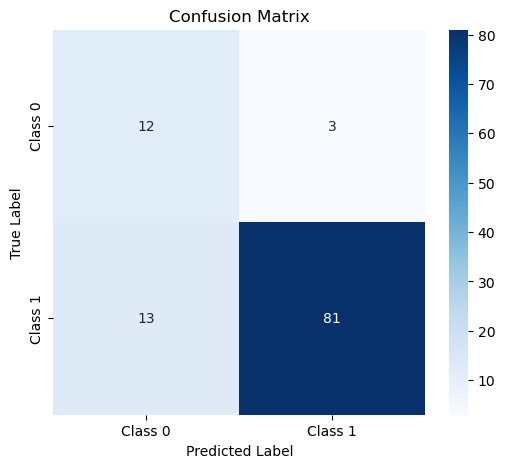

In [25]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Class-wise Metrics:

Class 0:
Sensitivity: 0.8000
Specificity: 0.8617

Class 1:
Sensitivity: 0.8617
Specificity: 0.8000

Overall Metrics:
Sensitivity: 0.8617
Specificity: 0.8000


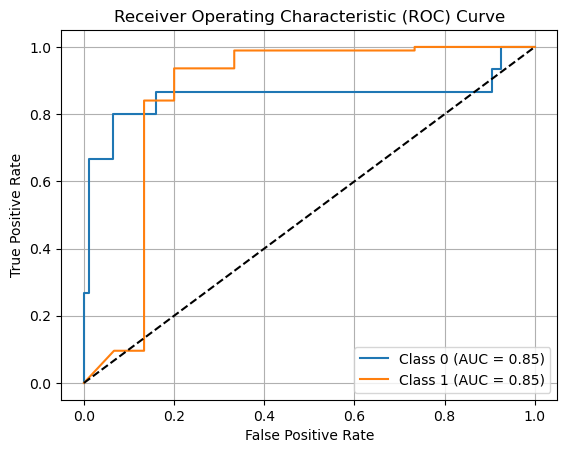

In [26]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")

# ROC Curve
def plot_roc_curve(y_test, y_scores, classes):
    y_test_bin = np.zeros((len(y_test), len(classes)))
    for i, c in enumerate(classes):
        y_test_bin[:, i] = (y_test == c).astype(int)
    
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test, y_probs, classes=np.unique(y))

NB - Balanced Dataset

In [27]:
# Load dataset
df = pd.read_csv("./Balanced_binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,-1.944044,1.891310,5.378017,-1.099764,0.319998,-0.107990,0.192998,-0.531588,-1.978358,0.505306,...,0.435838,-0.375777,-2.410484,1.307302,-0.447091,-1.205613,-0.758668,-1.115528,1.219782,1
1,0.548890,3.689146,-1.079215,-1.125497,6.892610,-0.114086,-0.129833,-4.471123,1.281707,2.509007,...,-0.515136,-1.814937,-0.659753,0.092014,1.173449,-0.887015,-0.657684,0.676340,0.379053,1
2,1.044743,2.804073,-1.779122,-0.358211,6.132624,-1.309396,-0.731316,-3.381683,-1.444734,3.028355,...,-0.928873,-1.592203,-0.389953,0.343527,0.740160,-0.244341,-1.337129,-0.168281,-0.464880,1
3,-2.848743,-2.220174,-0.498797,-0.054547,0.073406,0.927517,1.891807,-0.381548,0.017551,0.659493,...,0.662054,0.671306,-0.463003,-0.170516,0.249816,0.019505,-0.380889,-0.222127,0.364851,1
4,-0.715628,0.217362,2.032461,-0.144826,4.375660,-1.762026,1.335940,1.742721,-1.771379,0.819612,...,-0.428352,-0.511074,-0.346423,0.137622,-0.289325,-1.089344,-0.407556,-0.007071,0.117600,1


In [28]:
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
1    464
0    464
Name: count, dtype: int64


In [29]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (742, 29)
Test set shape: (186, 29)


In [31]:
"""
Scaling is not needed as it is a probability based model
"""

'\nScaling is not needed as it is a probability based model\n'


Accuracy: 91.935%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        90
           1       0.98      0.86      0.92        96

    accuracy                           0.92       186
   macro avg       0.92      0.92      0.92       186
weighted avg       0.93      0.92      0.92       186


Confusion Matrix:
[[88  2]
 [13 83]]


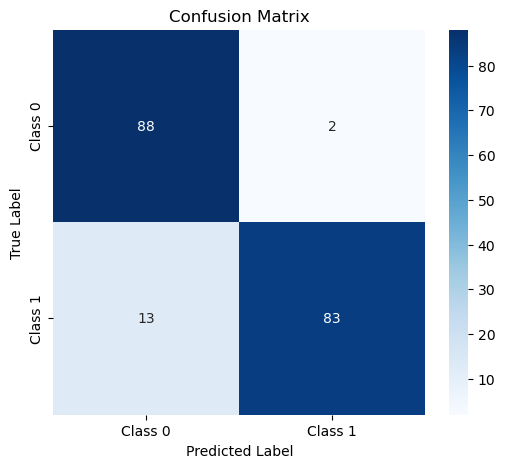

In [32]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Class-wise Metrics:

Class 0:
Sensitivity: 0.9778
Specificity: 0.8646

Class 1:
Sensitivity: 0.8646
Specificity: 0.9778

Overall Metrics:
Sensitivity: 0.8646
Specificity: 0.9778


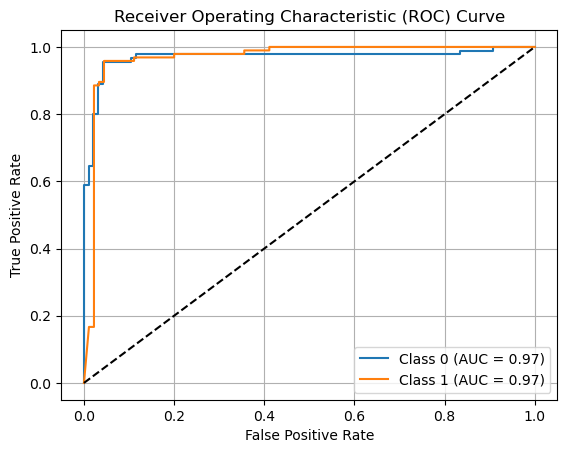

In [33]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")

# ROC Curve
def plot_roc_curve(y_test, y_scores, classes):
    y_test_bin = np.zeros((len(y_test), len(classes)))
    for i, c in enumerate(classes):
        y_test_bin[:, i] = (y_test == c).astype(int)
    
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test, y_probs, classes=np.unique(y))